## Script qui fait des cartes de différence entre les expériences PAMIP (régionales vs pd ou pi) de l'HN pour les variables 2D

## Choose the kernel env-gloenv-statsmodels
### Creation of the virtual env (already created)
module load python/gloenv_3.9

python3 -m venv --system-site-packages /data/scratch/globc/coquart/DATA_FOR_COMMON_JUPYTER_NOTEBOOKS/env-gloenv-statsmodels

source /data/scratch/globc/coquart/DATA_FOR_COMMON_JUPYTER_NOTEBOOKS/env-gloenv-statsmodels/bin/activate

pip install --upgrade pip

pip install statsmodels

pip install ipykernel

deactivate

### Add this environment to your jupyter kernel
source /data/scratch/globc/coquart/DATA_FOR_COMMON_JUPYTER_NOTEBOOKS/env-gloenv-statsmodels/bin/activate

python3 -m ipykernel install --user --name env-gloenv-statsmodels

close and reopen the notebook to see the new kernel env-gloenv-statsmodels and use it

### Remove a jupyter kernel
jupyter kernelspec list

jupyter kernelspec uninstall env-gloenv-statsmodels

In [1]:
#Libraries
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os, subprocess

from netCDF4 import Dataset
#from mpl_toolkits.basemap import Basemap
from scipy.stats import norm
import scipy.io as sio

##Script à loader
from def_interpol_2d import interpol_2d_G
from FDR import fdr_correction
from scipy import stats

##Carte
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.path as mpath
import matplotlib as mpl
import matplotlib.colors as mcolors

/data/softs/anaconda3-2020.07/envs/gloenv_py3.9/lib/python3.9/site-packages/pyproj/__init__.py:91: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_LIB or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


In [2]:
####INPUT
#2D variable (tas,psl...), zone (BK or Okhotsk), period to compare with simulation (pd or pi) 
var="tas"
zone = "BK"
#zone=Okhotsk
per="pd"
# per=pi
#Directory of new plots
dir_fig="../results/PLOTS/PAMIP/monthly_map/"

In [3]:
if per=="pd":
    simu_i = "pdSST-pdSIC"
elif per=="pi":
    simu_i = "pdSST-piArcSIC"
#Directory
if zone=="BK":
    dir_zone ='/data/scratch/globc/dcom/CMIP6/PAMIP/CNRM-CERFACS/CNRM-CM6-1/pdSST-fut'+zone+'SeasSIC'
else:
    dir_zone ='/data/scratch/globc/dcom/CMIP6/PAMIP/CNRM-CERFACS/CNRM-CM6-1/pdSST-fut'+zone+'SIC'
dir_pi = "/data/scratch/globc/dcom/CMIP6/PAMIP/CNRM-CERFACS/CNRM-CM6-1/"+simu_i

if var=="siconca":
    dom="SImon"
else:
    dom="Amon"
#Vector with data for all members
var_zone = np.zeros((100,14,128,256))
var_i = np.zeros((100,14,128,256))

In [4]:
#Loop for members
for i in range(100):
    
    name_pi="CNRM-CM6-1_"+simu_i+'_r'+str(i+1)+"i1p1f2"
    if zone=="BK":
        name_zone="CNRM-CM6-1_pdSST-fut"+zone+"SeasSIC_r"+str(i+1)+"i1p1f2"
        nc_file = dir_zone+"/"+name_zone+"/"+var+"_"+dom+"_CNRM-CM6-1_pdSST-fut"+zone+"SeasSIC_r"+str(i+1)+"i1p1f2_gr_200004-200105.nc"
    elif zone=="Okhotsk":
        name_zone="CNRM-CM6-1_pdSST-fut"+zone+"SIC_r"+str(i+1)+"i1p1f2"
        nc_file = dir_zone+"/"+name_zone+"/"+var+"_"+dom+"_CNRM-CM6-1_pdSST-fut"+zone+"SIC_r"+str(i+1)+"i1p1f2_gr_200004-200105.nc"
    fh = Dataset(nc_file, mode='r')
    
    lon = fh.variables['lon'][:]
    lat = fh.variables['lat'][:]
   
    var_data= fh.variables[var][:]
    var_units = fh.variables[var].units
    fh.close()
    
    lon[-1] = 359.9
    var_zone[i,:,:,:]=var_data
    
    nc_file = dir_pi+"/"+name_pi+"/"+var+"_"+dom+"_CNRM-CM6-1_"+simu_i+"_r"+str(i+1)+"i1p1f2_gr_200004-200105.nc"
    fh = Dataset(nc_file, mode='r')
    var_data2 = fh.variables[var][:]
    fh.close()    
    var_i[i,:,:,:]=var_data2

nm,nx,ny=var_data2.shape
#For 3D variables
level=1000

#Round for unit
if var=="psl":
    var_zone,var_i=var_zone/100,var_i/100
elif var=="pr":
    var_zone,var_i=var_zone*86400*30,var_i*86400*30

In [5]:
#Palette for map
if var =="pr" or var =="P-E" or var=="mrso" or var =="prc" or var =="prsn":
    palette="BrBG"
elif var=="siconca":
    palette="Reds_r"
else:
    palette="RdBu_r"


In [6]:
#Diff between simulations
Diff=np.mean(var_zone,axis=0)-np.mean(var_i,axis=0)
#ST

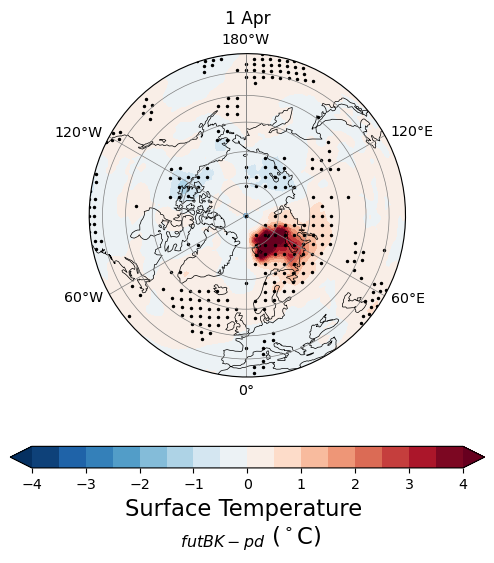

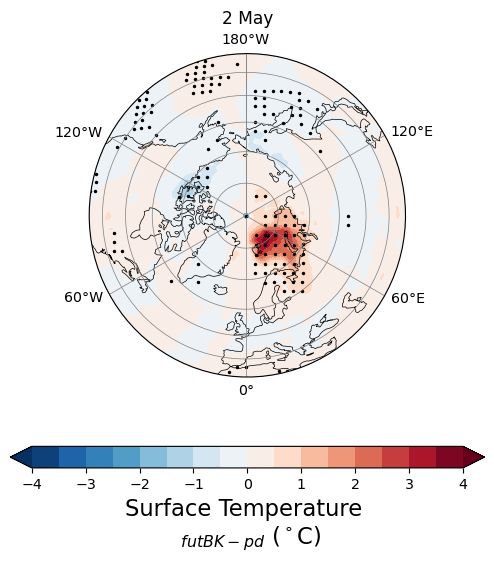

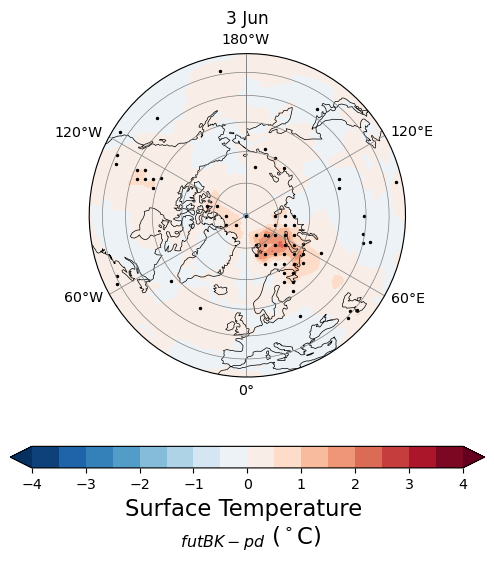

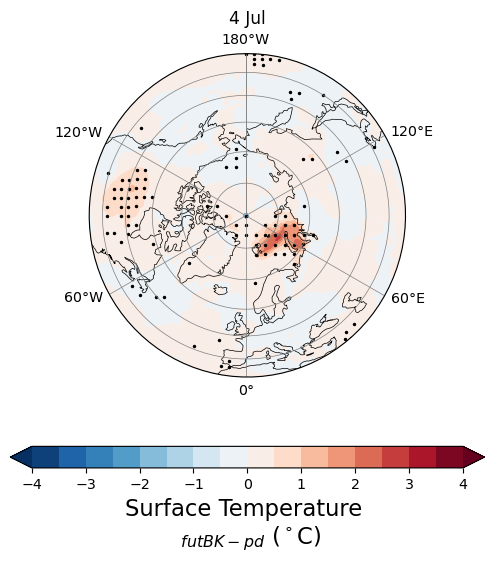

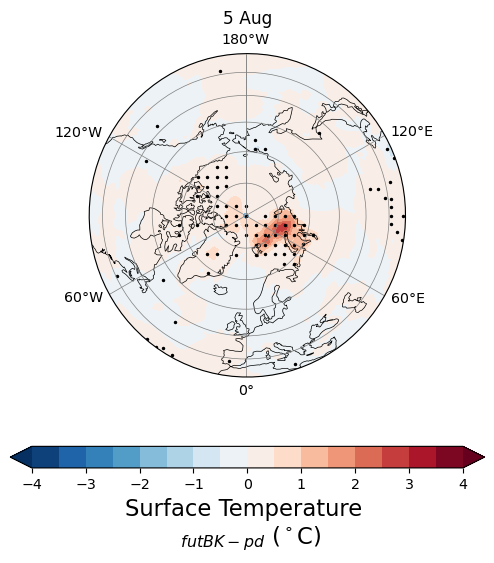

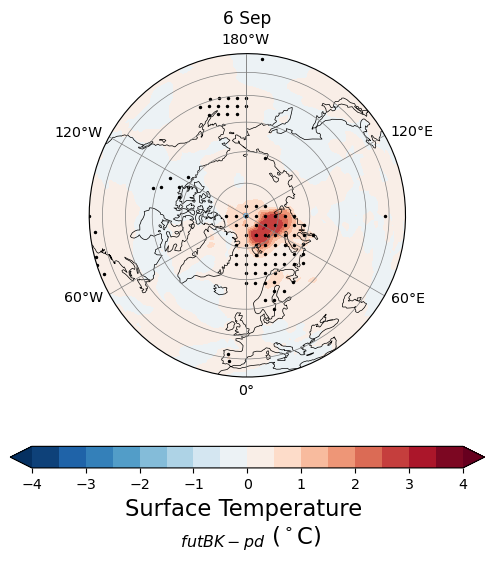

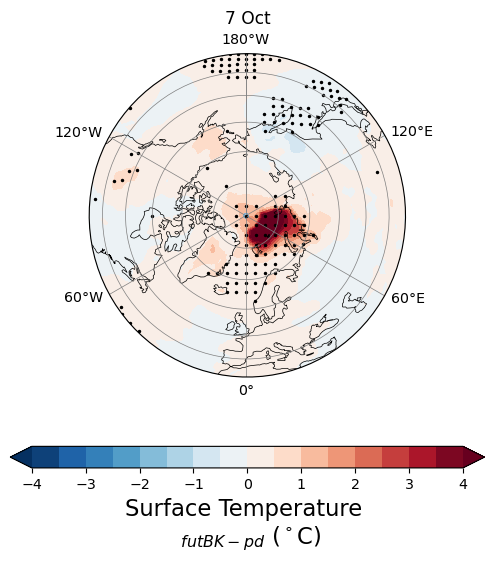

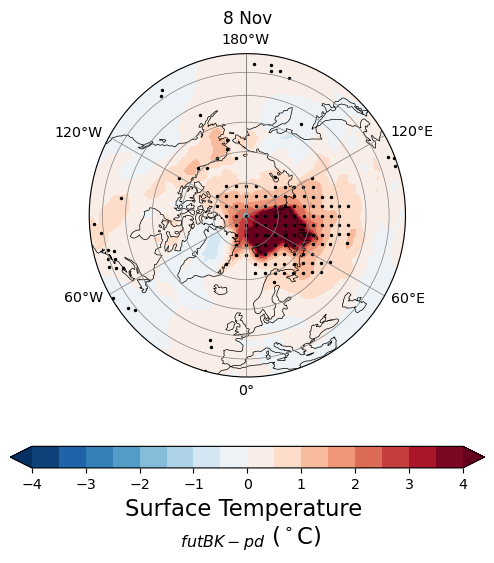

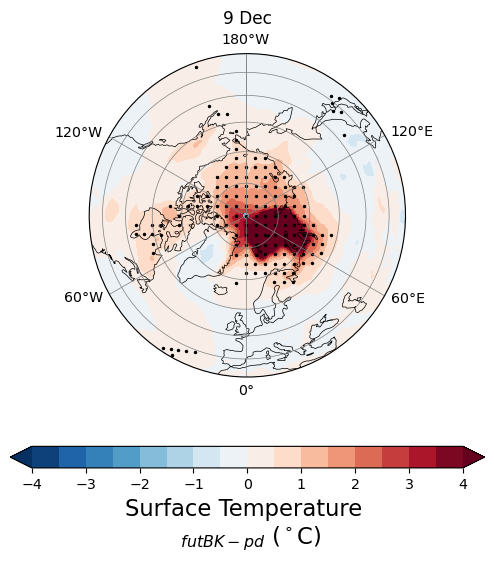

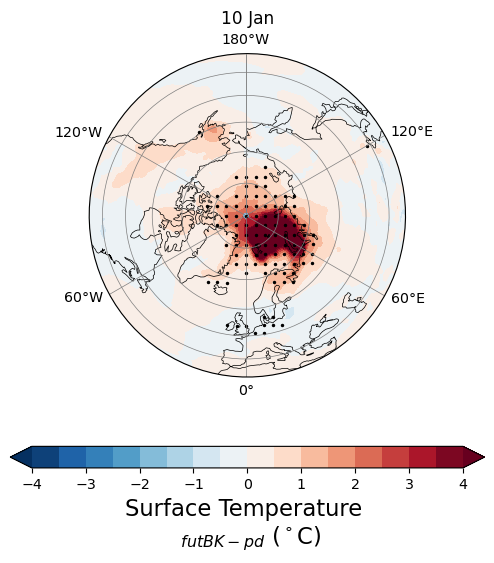

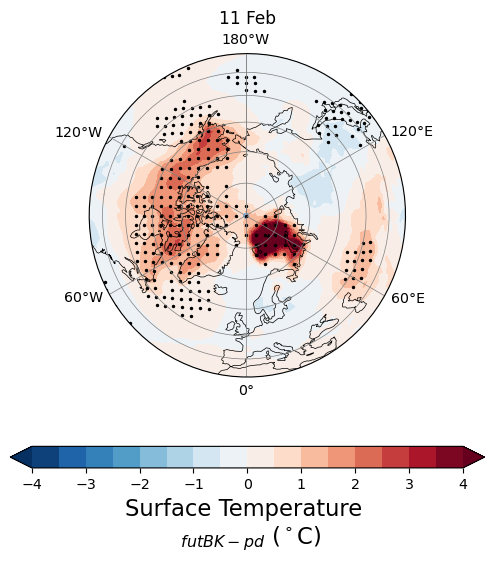

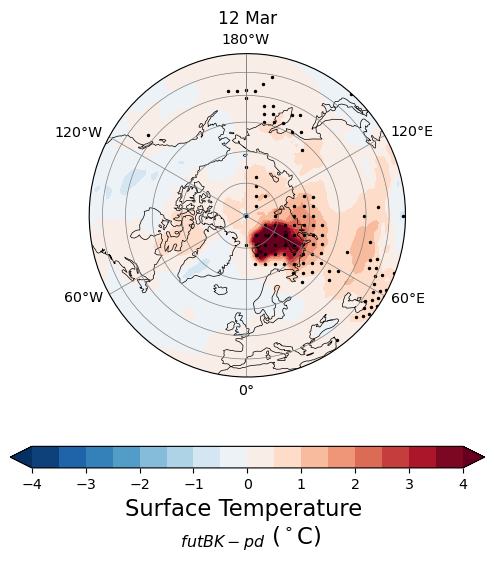

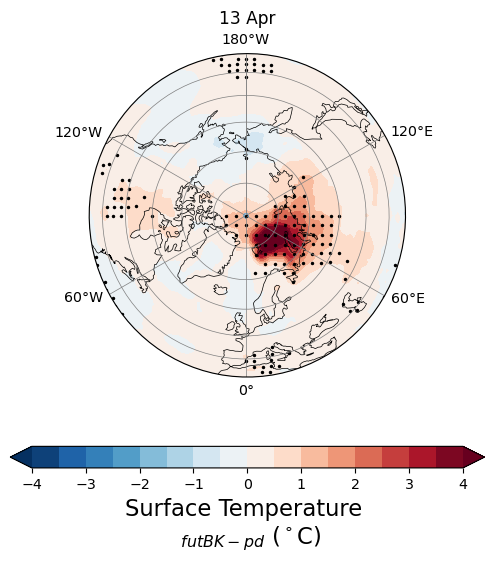

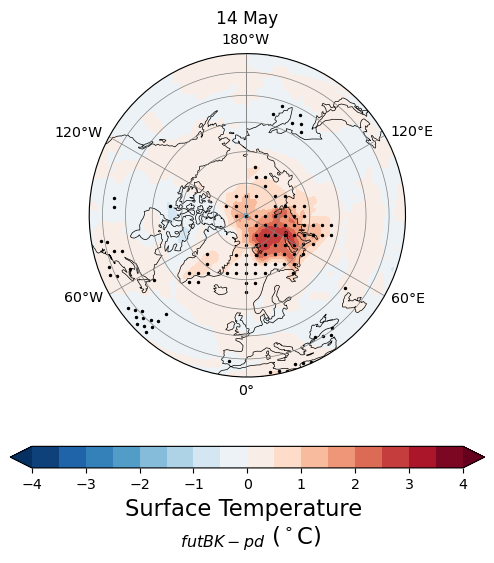

In [7]:
#Map
if var=="pr":
    scale=np.round(np.arange(-10,10.1,1),1)
    ylims = [30,90]
elif var=="siconca":
    scale=np.arange(-80,1,5)
    ylims = [40,90]
else:
    scale=np.round(np.arange(-4,4.1,0.5),1)
    ylims = [30,90]

xlims = [-180,180]
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)    

########Pour interpoller sur grille régulière
data_PLOT=sio.loadmat('LAT_eq_PN_51.mat')
LAT_RACMO = data_PLOT["LAT_eq"]
data_lon=sio.loadmat('LON_eq_PN_51.mat')
LON_RACMO = data_lon["LON_eq"]

for i in range(14):
    if i == 0:
        name = "Apr"
    elif i ==1:
        name = "May"
    elif i ==2:
        name = "Jun"
    elif i ==3:
        name = "Jul"
    elif i ==4:
        name = "Aug"
    elif i ==5:
        name = "Sep"
    elif i ==6:
        name = "Oct"
    elif i ==7:
        name = "Nov"
    elif i ==8:
        name = "Dec"
    elif i ==9:
        name = "Jan"
    elif i ==10:
        name = "Feb"
    elif i ==11:
        name = "Mar"
    elif i ==12:
        name = "Apr"
    elif i == 13:
        name = "May"

    if var!="siconca":
        ####Calcul p-val selon test de Kolmogorov 2 sample
        p_val = np.zeros((nx,ny))
        for n in np.arange(nx):
            for m in np.arange(ny):
                p_val[n,m] = stats.ks_2samp(var_i[:,i,n,m], var_zone[:,i,n,m])[1]
        p_val_fdr = fdr_correction(p_val)

        lon_mesh,lat_mesh = np.meshgrid(lon,lat)
        grid_stat = interpol_2d_G(p_val,lon_mesh,lat_mesh,LON_RACMO,LAT_RACMO)
        grid_stat=np.nan_to_num(grid_stat)
    fig = plt.subplots(figsize=(6, 6), dpi=102)
    plt.axis('off')
    ax = plt.axes(projection=ccrs.Orthographic(central_longitude=0.0,central_latitude=90.0))

    ax.set_extent(xlims+ylims, crs=ccrs.PlateCarree())

    ax.set_boundary(circle, transform=ax.transAxes)
    ax.stock_img()
    ax.coastlines("110m", linewidth=0.5, color="black")
    cs=ax.contourf(lon, lat, Diff[i,:,:],scale,transform=ccrs.PlateCarree(),cmap=palette,transform_first=False,extend="both")
    # Doing the gridlines we want
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5,color="grey")
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlocator = mticker.FixedLocator(np.arange(-180,181,60))
    gl.ylocator = mticker.FixedLocator(np.arange(-90,91,10))
    if var=="siconca":
        ax.add_feature(cfeature.LAND, zorder=100, edgecolor='k')
    else:
        #Dots for stat
        if var=="pr":
            cs1 = ax.scatter(LON_RACMO[grid_stat<0.05],LAT_RACMO[grid_stat<0.05],s=2,marker='o',color='k',transform=ccrs.PlateCarree())
        else:
            cs1 = ax.scatter(LON_RACMO[grid_stat<0.1],LAT_RACMO[grid_stat<0.1],s=2,marker='o',color='k',transform=ccrs.PlateCarree())

    # Add Colorbar
    cbar = plt.colorbar(cs,orientation="horizontal")

    #Nom échelle
    if var == "pr":
        cbar.set_label('Precipitation $_{fut'+zone+'-'+per+'}$ (mm)',fontsize=16)
    elif var =="tas":
        cbar.set_label('Surface Temperature \n $_{fut'+zone+'-'+per+'}$ ($^\circ$C)',fontsize=16)
    elif var == "psl":
        cbar.set_label('Sea Level Pressure $_{fut'+zone+'-'+per+'}$ (hPa)',fontsize=16)
    elif var =="hfss":
        cbar.set_label('Surface Sensible Heat Flux \n $_{fut'+zone+'-'+per+'}$ (W/m²)',fontsize=16)
    elif var =="hfls":
        cbar.set_label('Surface Latent Heat Flux \n $_{fut'+zone+'-'+per+'}$ (W/m²)',fontsize=16)
    elif var =="hf":
        cbar.set_label('Surface Turbulent Heat Flux \n $_{fut'+zone+'-'+per+'}$ (W/m²)',fontsize=16)
    elif var =="tos":
        cbar.set_label('SST $_{fut'+zone+'-'+per+'}$ ($^\circ$C)',fontsize=16)
    elif var =="P-E":
         cbar.set_label('P-E $_{fut'+zone+'-'+per+'}$ (mm) ',fontsize=16)
    elif var == "evspsbl":
        cbar.set_label('Evaporation $_{fut'+zone+'-'+per+'}$ (mm)',fontsize=16)
    elif var == "rsus":
        cbar.set_label('Surface Upwelling Shortwave \n Radiation $_{fut'+zone+'-pd}$ (W/m²)',fontsize=16)
    elif var == "rlut":
        cbar.set_label('TOA OLR $_{fut'+zone+'-'+per+'}$ (W/m²)',fontsize=16)
    elif var =="mrso":
        cbar.set_label('Soil Moisture Content $_{fut'+zone+'-'+per+'}$ (kg/m²)',fontsize=16)
    elif var =="prsn":
        cbar.set_label('Snow Precipitation $_{fut'+zone+'-'+per+'}$ (mm)',fontsize=16)
    elif var =="prc":
        cbar.set_label('Convective Precipitation $_{fut'+zone+'-'+per+'}$ (mm)',fontsize=16)
    elif var =="snw":
        cbar.set_label('Snow Depth $_{fut'+zone+'-'+per+'}$ (mm)',fontsize=16)
    elif var == "ua":
        cbar.set_label('Zonal Wind at '+str(level)+'hPa $_{fut'+zone+'-'+per+'}$ (m/s)',fontsize=16)
    elif var == "va":
        cbar.set_label('Meridional Wind at '+str(level)+'hPa $_{fut'+zone+'-'+per+'}$ (m/s)',fontsize=16)
    elif var =="ta":
        cbar.set_label('Temperature at '+str(level)+'hPa \n $_{fut'+zone+'-'+per+'}$ ($^\circ$C)',fontsize=16)
    elif var == "zg":
        cbar.set_label('Geopotential Height at '+str(level)+'hPa \n $_{fut'+zone+'-'+per+'} (dam)$',fontsize=16)
    elif var =="wap":
        cbar.set_label('Vertical velocity at '+str(level)+'hPa \n $_{fut'+zone+'-'+per+'} (hPa/s)$',fontsize=16)
    elif var=="siconca":
        cbar.set_label('Sea ice concentration $_{fut'+zone+'-'+per+'}$ (%)',fontsize=16)
    # Add Title
    plt.title(str(i+1)+" "+ name)
    plt.savefig(dir_fig + str(i)+"_"+name+".png",dpi=200,bbox_inches='tight')